In [1]:
import SimpleITK as sitk
import os
import dosma as dm
import numpy as np
from dosma import preferences
from dosma.scan_sequences import QDess, CubeQuant, Cones
from dosma.tissues import FemoralCartilage
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

220518-19:18:41,267 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


In [2]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
fc = FemoralCartilage()

# Perform analyticial voxelwise T2 measurement for femoral cartilage
# while suppressing fat and fluid regions for higher SNR.
qdess = QDess.from_dicom("../lib/resource/data/qdess", verbose=True)

t2map = qdess.generate_t2_map(fc, suppress_fat=True, suppress_fluid=True)

# Clip the estimated T2 values between [0, 80]
t2map.volumetric_map = np.clip(t2map.volumetric_map, 0, 80)

  0%|          | 0/160 [00:00<?, ?it/s]

/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mask * echo_2 / echo_1
/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo_2 / echo_1
/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: overflow encountered in true_divide
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)
/Users/huozimu/opt/anaconda3/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: divide by zero encountered in log
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)


In [4]:
cq = CubeQuant.from_dicom("../lib/resource/data/cubequant", verbose=True, num_workers=4)

  0%|          | 0/288 [00:00<?, ?it/s]

In [5]:
im1 = t2map.volumetric_map.A.astype(np.float64)
im2 = cq.volumes[0].A.astype(np.float64)

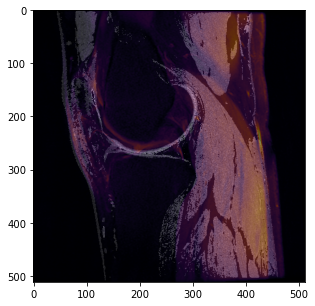

In [6]:
_, ax = plt.subplots(1,1, figsize=(5,5))
plt.imshow(im1[..., 32], cmap="gray")
plt.imshow(im2[..., 32], cmap="inferno", alpha=0.4, interpolation="bilinear")

In [7]:
fixed_image = sitk.GetImageFromArray(im1)
moving_image = sitk.GetImageFromArray(im2)

In [8]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    initial_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

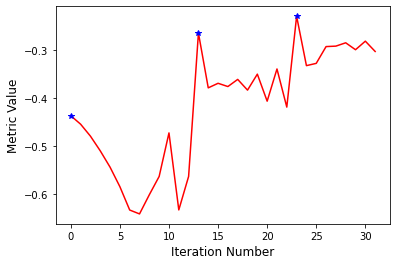

In [9]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [10]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)

In [11]:
t1 = sitk.GetArrayViewFromImage(fixed_image)
t2 = sitk.GetArrayFromImage(moving_resampled)

In [12]:
def show(ramp):
    _, ax = plt.subplots(1,1, figsize=(5,5))
    plt.imshow(t1[...,int(ramp)], cmap="gray")
    plt.imshow(t2[...,int(ramp)], cmap="inferno", alpha=0.5, interpolation="bilinear")

interact(show, ramp = widgets.FloatSlider(value=10,
                                               min=0,
                                               max=80,
                                               step=1))

interactive(children=(FloatSlider(value=10.0, description='ramp', max=80.0, step=1.0), Output()), _dom_classes…

<function __main__.show(ramp)>

In [13]:
from itkwidgets import view
view(fixed_image, rotate=True, axes=True, vmin=4000, vmax=17000, gradient_opacity=0.9)

Viewer(axes=True, geometries=[], gradient_opacity=0.9, point_sets=[], rendered_image=<itk.itkImagePython.itkIm…